In [500]:
import time
import numpy as np
import math
import matplotlib.pyplot as plt
from multiprocessing import Pool
import random
import timeit
import copy
import pandas as pd
import warnings
import scipy.integrate as integrate
warnings.filterwarnings('ignore')
import sys,os
sys.path.append(os.path.abspath("../../"))
from LBL_funcs_waterRTM import *
import re
import scipy.integrate as integrate

In [501]:
data = np.genfromtxt('../../data/profiles/ASTMG173.csv', delimiter=',', skip_header=1,  # in wavenumber basis
                     names=['wavelength', 'column2', 'column3', '37d_irrdiance'])
nu = np.arange(2500,33333+5,5)  # cm-1
ref_lam = data['wavelength'][1:]  # nm
ref_E = data['37d_irrdiance'][1:]  # Direct+circumsolar W/[m2*nm]
ref_E_nu=-ref_E*ref_lam**2/1e7  # W/[m2*nm-1] to W/[m2*cm-1]
F_dw_os = -np.interp(-nu, -1e7/ref_lam, ref_E_nu)  # W/[m2*cm-1] 

In [502]:
import scipy.integrate as integrate

I2 = integrate.trapz(F_dw_os, nu)
I1 = integrate.trapz(ref_E,ref_lam)
F_dw0 = I2
print(f"{I2} W/m-2")
print(I1)

900.1446337433081 W/m-2
900.139329284215


## extract file

In [503]:
def calculateF(res,nu):
    F_gas = res.item().get('F_n_abs')
    N_layer = F_gas.shape[0]
    F_total = 0
    items1 = ['F_n_abs', 'F_n_abs_rights','F_n_abs_leftn','F_n_abs_fronte','F_n_abs_backw']
    for item in items1:
        temp = res.item().get(item)
        F_i = integrate.trapz(temp, nu, axis=1)
        F_total += np.sum(F_i)
    F_1stLayer = res.item().get("F_n_abs")[-2]  # first layer is -2, -1 is incident E.
    F_body = res.item().get("F_n_abs")[1:-2]  # 0 is bottom
    F_edge = res.item().get('F_n_abs_rights') + res.item().get('F_n_abs_leftn') \
             + res.item().get('F_n_abs_fronte') + res.item().get('F_n_abs_backw')
    F_bottom= res.item().get('F_n_abs')[0]
    F_dw = res.item().get('F_n_dw')
    F_uw = res.item().get('F_n_uw')
    return F_bottom, F_1stLayer, F_body, F_edge, F_dw

def check_convergence(y, mean):
    diff = [np.nan]
    for i in range(1, len(y)):
        dy = abs(y[i] - y[i-1])
        diff.append(1-dy/mean*100)
    return diff

depth = 200
width = 10*100
long = 10*100
path = "./"
Fls = os.listdir(path)

Fls = [s for s in Fls if s.endswith('.npy')]
len(Fls)

7

In [504]:
# 1. Tmperature extracted from file name
Angle = []
for string in Fls:
    match = re.search(r'_([\d.]+)theta', string)
    if match:
        Angle.append(int(match.group(1)))
df1 = pd.DataFrame({"Angle":Angle})

# 2. extract all kinds of energy and save it as pandas
# allocate a empty dataframe
df2 = pd.DataFrame(columns=["F_bottom","F_1stLayer","F_body","F_edge","F_dw"])
for i in range(len(Fls)):
    res = np.load(Fls[i], allow_pickle=True)
    columns = ["F_bottom", "F_1stLayer", "F_body", "F_edge", "F_dw"]
    values = calculateF(res, nu)
    df2.loc[i, columns] = values
dataf = pd.concat([df1, df2], axis=1)
del df1, df2

df = dataf.sort_values(by='Angle')

df0 = df.iloc[0]
print(df0['F_dw'].shape)
# layer = 202, 1 TOW, 1 bottom, 200 layers.
# 0 = bottom, -1 TOW
np.sum(df0['F_dw'][-1])*5

(202, 6168)


900.1731235538831

## A. Angle's impact to the water received

In [505]:
# extract temp == 5800
df = dataf.sort_values(by='Angle')
df.set_index(df['Angle'].values,inplace=True)
#df.drop(df.columns[0],axis=1, inplace=True)
#df.drop(df.columns[-1],axis=1, inplace=True)

In [506]:
df_sum = df.applymap(np.sum)
# For renaming columns to reflect they have been summed
df_sum.columns = [f'{col}_sum' for col in df_sum.columns]
total = F_dw0/5
df_sum.drop(df_sum.columns[0],axis=1, inplace=True)
df_sum.drop(df_sum.columns[-1],axis=1, inplace=True)
df_ratio = df_sum.div(total,axis=0)
df_ratio["Reflection rate"] = 1-df_ratio.sum(axis=1)
#df_ratio.drop(df_ratio.columns[0],axis=1, inplace=True)
df_ratio

,F_bottom_sum,F_1stLayer_sum,F_body_sum,F_edge_sum,Reflection rate
0,0.346323,0.213492,0.427575,0.004685,0.007924
15,0.328743,0.210530,0.418076,0.015138,0.027513
30,0.318613,0.213915,0.416677,0.022442,0.028353
45,0.305255,0.218092,0.413420,0.028561,0.034672
60,0.283405,0.217925,0.400199,0.032946,0.065524
75,0.225548,0.188639,0.335494,0.034195,0.216124
85,0.116885,0.101329,0.177995,0.019328,0.584463


#### validation

In [13]:
df_ratio['F_1stLayer_sum'] = df_ratio['F_1stLayer_sum']+df_ratio['F_body_sum']
df_ratio

,F_bottom_sum,F_edge_sum,F_body_sum,F_1stLayer_sum
0,0.346323,0.004685,0.427575,0.641068
15,0.328743,0.015138,0.418076,0.628606
30,0.318613,0.022442,0.416677,0.630592
45,0.305255,0.028561,0.413420,0.631512
60,0.283405,0.032946,0.400199,0.618125
75,0.225548,0.034195,0.335494,0.524133
85,0.116885,0.019328,0.177995,0.279323


In [14]:
df_ratio['F_bottom_sum'] = df_ratio['F_bottom_sum']+df_ratio['F_edge_sum']

In [15]:
df_ratio

,F_bottom_sum,F_edge_sum,F_body_sum,F_1stLayer_sum
0,0.351008,0.004685,0.427575,0.641068
15,0.343880,0.015138,0.418076,0.628606
30,0.341055,0.022442,0.416677,0.630592
45,0.333816,0.028561,0.413420,0.631512
60,0.316351,0.032946,0.400199,0.618125
75,0.259743,0.034195,0.335494,0.524133
85,0.136214,0.019328,0.177995,0.279323


In [16]:
exp_bott = np.array([33.8, 33.6, 33.1, 32.1, 30.1, 24.5])/100
exp_water = np.array([64.2, 64.4, 64.8, 65.1, 63.9, 54.3])/100
angle = [0,15,30,45,60,75]

# rho=0.0
exp_bott = np.array([33.8,  33.6, 33.1, 32.1, 30.1, 24.5])
exp_water = np.array([64.2, 64.4, 64.8, 65.1, 63.9, 54.3])
exp_reflec = np.array([6.6, 6.6,  6.6,  7.2,  10.1, 24.7])

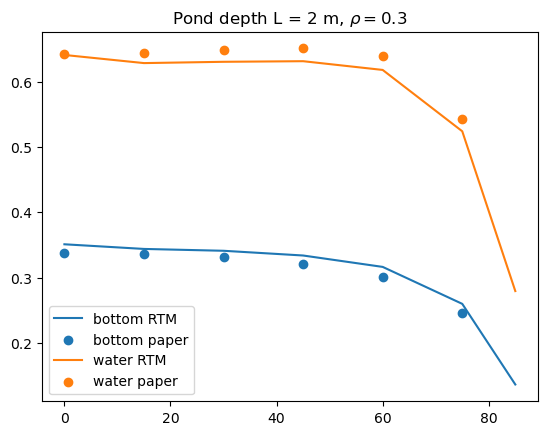

In [17]:
plt.plot(df_ratio.index, df_ratio['F_bottom_sum'].values,label='bottom RTM')
plt.scatter(angle, exp_bott,label='bottom paper')

plt.plot(df_ratio.index, df_ratio['F_1stLayer_sum'].values,label='water RTM')
plt.scatter(angle, exp_water,label='water paper')

plt.title(r'Pond depth L = 2 m, $\rho =0.3$')
plt.legend(loc='lower left')
plt.show()

#### validation end

In [507]:
df_ratio = df_ratio[['F_bottom_sum','F_edge_sum','F_body_sum','F_1stLayer_sum','Reflection rate']]
df_ratio = df_ratio.reindex([0,15,30,45,60,75,85])
df_ratio.columns = ['Bottom', 'Sides', 'Body', 'Surface','Reflected']
df_ratio

,Bottom,Sides,Body,Surface,Reflected
0,0.346323,0.004685,0.427575,0.213492,0.007924
15,0.328743,0.015138,0.418076,0.210530,0.027513
30,0.318613,0.022442,0.416677,0.213915,0.028353
45,0.305255,0.028561,0.413420,0.218092,0.034672
60,0.283405,0.032946,0.400199,0.217925,0.065524
75,0.225548,0.034195,0.335494,0.188639,0.216124
85,0.116885,0.019328,0.177995,0.101329,0.584463


In [138]:
font = 15
fontfml = 'Times New Roman'
plt.rcParams['font.size'] = font
plt.rcParams['font.family'] = fontfml
plt.rcParams['mathtext.fontset']='custom'
plt.rcParams['mathtext.rm'] =fontfml
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

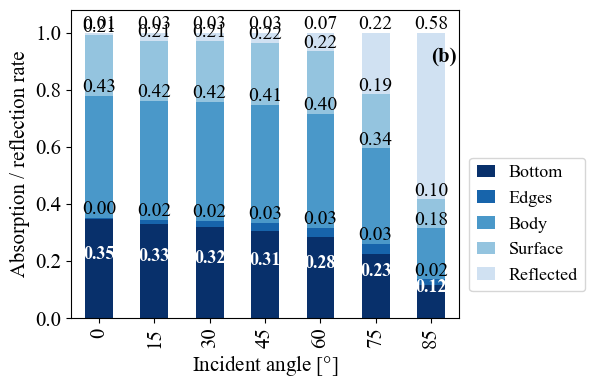

In [146]:
df_ratio.columns = ['Bottom', 'Edges', 'Body', 'Surface','Reflected']
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


figsize = (5, 4)
plt.rcParams['font.size'] = font
plt.rcParams['font.family'] = fontfml

# Create a colormap
cmap = plt.cm.get_cmap('Blues_r')  # viridis,summer

# Create an array of colors from the colormap
colors = cmap(np.linspace(0, 1, len(df_ratio.columns)+1))

# Plot the stacked bar chart with the colors
ax = df_ratio.plot(kind='bar', stacked=True, color=colors,figsize=figsize,
                   xlabel=r"Incident angle [$\degree$]", ylabel="Absorption / reflection rate")

ax.legend(loc="upper right",ncol=1, bbox_to_anchor=(1.35, 0.55),handlelength=1,fontsize=font-2)

yticks = np.arange(0.1, 1+0.1, 0.1)
#for i in range(len(yticks)):
#    ax.axhline(yticks[i], color='gray', linestyle='--', linewidth=0.8)
color='white'

# Display the value on each bar
i = 0 
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    #print(x + width/2,y + height/2)
    if i < 7:
        ax.text(x + width/2, 
            y + height/2 + 0.05, 
            '{:.2f}'.format(height), 
            color=color,
            ha='center', 
            va='center',
            weight = 'bold',
            fontsize=font-2,
            family=fontfml)
        i=i+1
    else:
        ax.text(x + width/2, 
            y + height+0.03, 
            '{:.2f}'.format(height),
            #color=color,
            ha='center', 
            va='center',
            #weight = 'bold',
            fontsize=font-1,
            family=fontfml)
ax.set_ylim(0,1.08)
ax.text(6, 0.9, '(b)', fontsize=font,fontfamily=fontfml, weight='bold')
fig_dir = './../../figure/'
#ax.get_figure().savefig(fig_dir+'solarangle.png', dpi=300, bbox_inches='tight')
plt.show()

### diffuse solar radiation

In [508]:
rspath = "./../SolarDepth/"
Fls = os.listdir(rspath)

# all files.npy in the folder
Fls = [s for s in Fls if s.endswith('SWresults_200layer_1000bundle_diffuse.npy')]
len(Fls)

1

In [509]:
# 2. extract all kinds of energy and save it as pandas
# allocate a empty dataframe
df2 = pd.DataFrame(columns=["F_bottom","F_1stLayer","F_body","F_edge","F_dw"])
for i in range(len(Fls)):
    res = np.load(rspath+Fls[i], allow_pickle=True)
    columns = ["F_bottom", "F_1stLayer", "F_body", "F_edge", "F_dw"]
    values = calculateF(res, nu)
    df2.loc[i, columns] = values

# the refraction rate
print(np.trapz(df2["F_dw"][0][-1], nu)/ F_dw0)

0.9299061326676726


In [510]:
df2["F_inE"]=df2["F_dw"].apply(lambda x:np.sum(x[-1,:]))
df_sum = df2.applymap(np.sum)
df_sum.drop(df_sum.columns[-2],axis=1, inplace=True)
df_sum

,F_bottom,F_1stLayer,F_body,F_edge,F_inE
0,51.369501,37.588876,71.070715,6.135443,167.415245


In [511]:
# For renaming columns to reflect they have been summed
#df_sum = df2.applymap(np.sum)
df_sum.columns = [f'{col}_sum' for col in df_sum.columns]
total = F_dw0/5
defus_ratio = df_sum.div(total,axis=0)
defus_ratio['Reflectino rate'] = 1-defus_ratio['F_inE_sum']
defus_ratio.drop(defus_ratio.columns[-2],axis=1, inplace=True)
defus_ratio = defus_ratio[['F_bottom_sum','F_edge_sum','F_body_sum','F_1stLayer_sum','Reflectino rate']]
defus_ratio

,F_bottom_sum,F_edge_sum,F_body_sum,F_1stLayer_sum,Reflectino rate
0,0.28534,0.03408,0.394774,0.208794,0.070065


In [512]:
defus_ratio.columns = ['Bottom', 'Sides', 'Body', 'Surface','Reflected']
defus_ratio.index = ['diffuse'] * len(defus_ratio)

defus_ratio

,Bottom,Sides,Body,Surface,Reflected
diffuse,0.28534,0.03408,0.394774,0.208794,0.070065


In [513]:
np.sum(defus_ratio.values)

0.9930527290156715

In [568]:
df_new=pd.concat([df_ratio,defus_ratio])
df_new = df_new.reindex([0,15,30,45,60,'diffuse', 75,85])
df_new['Surface']=np.floor(df_new['Surface'].values*100)/100
df_new.at[df_new.index[-1], 'Sides']=0.03
df_new

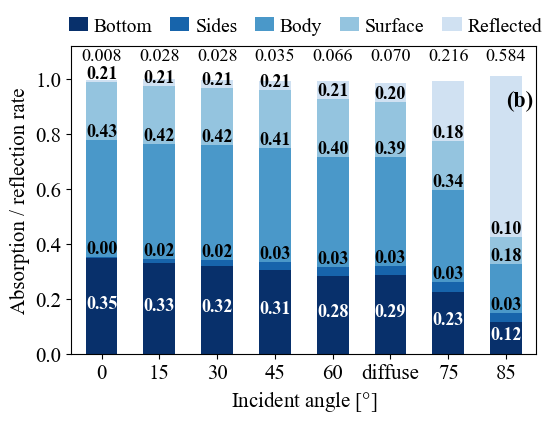

In [570]:
font = 15
fontfml = 'Times New Roman'
plt.rcParams['mathtext.fontset']='custom'
plt.rcParams['mathtext.rm'] =fontfml
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

plt.rcParams['font.size'] = font
plt.rcParams['font.family'] = fontfml

# Create a colormap
figsize = (6, 4)
cmap = plt.cm.get_cmap('Blues_r')  # viridis,summer
# Create an array of colors from the colormap
colors = cmap(np.linspace(0, 1, len(df_new.columns)+1))
new_colors = np.vstack([colors, rgba_color])
# Plot the stacked bar chart with the colors
ax = df_new.plot(kind='bar', stacked=True, color=new_colors, figsize=figsize,
                 width=0.55,
                 xlabel=r"Incident angle [$\degree$]", ylabel="Absorption / reflection rate")
yticks = np.arange(0.1, 1+0.1, 0.1)
#for i in range(len(yticks)):
#    ax.axhline(yticks[i], color='gray', linestyle='--', linewidth=0.8)
color='white'

# Display the value on each bar
i = 0 
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    #print(x + width/2,y + height/2)
    if i < 8:
        ax.text(x + width/2, 
            y + height/2 + 0.01, 
            '{:.2f}'.format(height), 
            color=color,
            ha='center', 
            va='center',
            weight = 'bold',
            fontsize=font-2,
            family=fontfml)
        i=i+1
    elif 27 < i< 32:
        ax.text(x + width/2, 
            y+height+0.03, 
            '{:.2f}'.format(height),
            #color=ref_color,
            ha='center', 
            va='center',
            weight = 'bold',
            fontsize=font-2,
            family=fontfml)
        i=i+1
    elif 32 <= i:
        ax.text(x + width/2, 1.08, 
            '{:.3f}'.format(height),
            #color="C2",
            ha='center', 
            va='center',
            #weight = 'bold',
            fontsize=font-2,
            family=fontfml)
        i=i+1
    else:
        ax.text(x + width/2, 
            y + height+0.03, 
            '{:.2f}'.format(height),
            #color=color,
            ha='center', 
            va='center',
            weight = 'bold',
            fontsize=font-2,
            family=fontfml)
        i=i+1
#ax.set_xlabel(r"Incident angle [$\degree$]",fontsize=font,family=fontfml)
ax.set_xticklabels([0,15,30,45,60,'diffuse',75,85], rotation = 0)
#ax.set_xticks(rotation = 0)
ax.set_ylim(0,1.12)
ax.text(7, 0.9, '(b)', fontsize=font+1,fontfamily=fontfml, weight='bold')
ax.legend(loc="upper right", ncol=5, bbox_to_anchor=(1.05, 1.15), 
          columnspacing=0.9,handletextpad=0.3,edgecolor='none',
          handlelength=1,fontsize=font-1)
fig_dir = './../../figure/'
ax.get_figure().savefig(fig_dir+'solarangle.png', dpi=300, bbox_inches='tight')
plt.show()